## Preprocessing the data

Resizing the datasets into small size and rearranging to make training more faster, <br>
Source datasets: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [ ]:
from google.colab import drive
from google.colab import files
import os
import zipfile
import cv2
import shutil
from shutil import move
from shutil import copy
from shutil import make_archive
import pandas as pd

In [ ]:
# Mounting google drive
drive.mount('/content/gdrive')

# Upload the .json file to the colab
files.upload() 

# install some requirements for kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
# Change directory to Google Drive
os.chdir("/content/gdrive/MyDrive/datasets")
os.mkdir(f'{os.getcwd()}/skin-cancer-mnist-ham10000') # Make directory for MNIST HAM 10000 
os.chdir(f'{os.getcwd()}/skin-cancer-mnist-ham10000') # Change directory to MNIST HAM 10000 

In [ ]:
# Downloading the datasets using Kaggle API
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [ ]:
# Extracting the datasets
local_zip = f'{os.getcwd()}/skin-cancer-mnist-ham10000.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f'{os.getcwd()}/')
zip_ref.close()

# Removing the old 'huge' zip
os.remove(f'{os.getcwd()}/skin-cancer-mnist-ham10000.zip')

In [ ]:
# Resizing function
def resize_img(SOURCE, DEST, SIZE=64):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  print(len(files))
  for filename in files:
    if '.jpg' in filename:
      img = cv2.imread(f"{SOURCE}{filename}")
      resize_img = cv2.resize(img, (SIZE,SIZE))
      cv2.imwrite(f"{SOURCE}/{filename}", resize_img)
      move(f"{SOURCE}/{filename}",f"{DEST}/{filename}")

os.mkdir(f'{os.getcwd()}/HAM10000') # Because file in zip is separate by 2 parts, 
                                    # so we create new directory to save all parts
                                    # in one folder to make resizing more easy

# Resizing the image
resize_img(f'{os.getcwd()}/HAM10000_images_part_1/',f'{os.getcwd()}/HAM10000/')
resize_img(f'{os.getcwd()}/HAM10000_images_part_2/',f'{os.getcwd()}/HAM10000/')
resize_img(f'{os.getcwd()}/ham10000_images_part_1/',f'{os.getcwd()}/HAM10000/')
resize_img(f'{os.getcwd()}/ham10000_images_part_2/',f'{os.getcwd()}/HAM10000/')

# Remove some dir, to make directory more clean
os.rmdir(f'{os.getcwd()}/HAM10000_images_part_1')
os.rmdir(f'{os.getcwd()}/HAM10000_images_part_2')
os.rmdir(f'{os.getcwd()}/ham10000_images_part_1')
os.rmdir(f'{os.getcwd()}/ham10000_images_part_2')

# Checking how much file in HAM10000 to make sure there is no file lost
print(len(os.listdir(f'{os.getcwd()}/HAM10000'))) # 10015

In [ ]:
# Converting lesion type to more readable format
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Reading the csv file
df = pd.read_csv(f'{os.getcwd()}/HAM10000_metadata.csv')

# Adding more columns in csv
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

# Writing new metadata.csv
df.to_csv(f'{os.getcwd()}/metadata.csv')

In [ ]:
os.chdir('/content/gdrive/MyDrive/datasets/')
make_archive('ham10000', 'zip', '/content/gdrive/MyDrive/datasets/skin-cancer-mnist-ham10000/') # Create the new zip file

'/content/gdrive/MyDrive/datasets/ham10000.zip'

We successfully resizing the file from 5 GB to only 60 MB.
After that, we host the zip file to Google Drive <br> here is the links: https://drive.google.com/file/d/1XaYK3zz8Gp7UwJNnJw65fn7wNapW8ibh/view?usp=sharing

## Training the datasets

Processing the dataset, and training the dataset

In [ ]:
from google.colab import drive # colab only
from google.colab import files # colab only

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import zipfile
import pandas as pd
import requests

from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model

from imblearn.over_sampling import RandomOverSampler 

In [ ]:
drive.mount('/content/drive')

In [ ]:
class_names = ['AKIEC','BCC','BKL','DF','NV','MEL','VASC']

class_names_long = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']

In [ ]:
# Download the file

def download_file(urls, unzip=True, remove_after_unzip=False, google_drive=False, ext='zip'):

  """
  Downloading the zip files (or not a zip one)
  This function will be downloaded the zip (or not a zip one) files from Internet
  Note: from Google Drive there is a different implementation to download the file

  args:
    urls : url of the file, is required
    unzip : choosing if you want to unzip the downloaded zip file (or not a zip one), default is True
    remove_after_unzip : removing the file after unzip, default is False
    google_drive : if you want to download the file directly from Google Drive, default is False 
    ext : if you want to download non a zip files, is required
  
  """
  
  url = urls
  CHUNK_SIZE = 32768
  file_tmp = f'tmp.{ext}'

  # If Downloading from Google Drive
  if google_drive:

    # Get the token
    def get_confirm_token(response):
      
      for key, value in response.cookies.items():
        if key.startswith('download_warning'):
          return value
      return None
    
    url_raw = 'https://docs.google.com/uc?export=download'
    file_id = url.split('/')[-2] # Split the file id
    session = requests.Session() # Get session
    response = session.get(url_raw, params={'id': file_id}, stream=True) # Get the response
    token = get_confirm_token(response) # Get the token

    # If there is token
    if token:
      response = session.get(url_raw, params={'id': file_id, 'confirm': token}, stream=True) # Get the response
    
    # Save the response as zip file
    with open(file_tmp, 'wb') as f:
      for chunk in response.iter_content(CHUNK_SIZE):
        if chunk:
          f.write(chunk)
  
  # If not from Google Drive
  else:
    filedata = get_file(origin=url, fname=os.path.join(os.getcwd(), file_tmp)) # Get the response from URL

  # Extract the zip files
  if unzip:
    local_zip = file_tmp
    zip_ref = zipfile.ZipFile(local_zip, 'r') # Extract 
    zip_ref.extractall(f'{os.getcwd()}/') # Extract
    zip_ref.close()
    # Remove the zip file after unzip
    if remove_after_unzip:
      os.remove(file_tmp)  
  
  # If not a zip file
  else:
    return file_tmp
  
# 128x128
#download_zip('https://drive.google.com/file/d/1HD8R2ond9bibVS1JXMLwk3d4NSdVRrWv/view?usp=sharing', remove_after_unzip=True) # <- here is the hosted file from previous resizing

# 64x64 <- reducing memory leak
download_file('https://drive.google.com/file/d/1XaYK3zz8Gp7UwJNnJw65fn7wNapW8ibh/view?usp=sharing', remove_after_unzip=True, google_drive=True)

In [ ]:
def define_dataset(csv):

  """
  Define the datasets from CSV
  This function will be define the datasets
  from existing metadata csv files

  args:
    csv : Load CSV files, is required
    
  """
  
  df = pd.read_csv(csv) # Reading the csv files from pandas
  img = df['image_id'] # Define the Feature 
  target = df['cell_type_idx'].values # Define the Labels
  
  return img, target

img, target = define_dataset('metadata.csv')

In [ ]:
def split_data(x, y, test_size=0.2, validation_size=0.05, balancing=False):

  """
  Splitting the datasets
  
  args:
    x : path to or datasets that corresponding to feature of the datasets, is required
    y : path to or datasets that corresponding to label of the datasets, is required
    test_size : split the datasets into train and test datasets, default is 0.2 
    validation_size : split the datasets into train and validation datasets, default is 0.05
    balancing : balanced the datasets if not balanced, default is False

  """
  
  # Balancing the datasets, if the datasets not balanced so this function will balanced them
  def balancing_dataset(x_train, x_val, y_train, y_val):
    
    # Balancing with OverSampler method from Imbalanced Learn
    # Source: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
    oversample = RandomOverSampler()
    x_train, y_train  = oversample.fit_resample(x_train.values.reshape(-1,1),y_train)
    x_val, y_val  = oversample.fit_resample(x_val.values.reshape(-1,1),y_val)
    
    return x_train, x_val, y_train, y_val
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_size)

  # If balancing is True, so the datasets will be balancing
  if balancing:
    x_train, x_val, y_train, y_val = balancing_dataset(x_train, x_val, y_train, y_val)
  
  # Print the results of splitting
  print("Train: ", x_train.shape[0]), print("Val: ", x_val.shape[0]), print("Test: ", x_test.shape[0]), 
  
  return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = split_data(img, target, balancing=True, test_size=0.2, validation_size=0.05)

Train:  44534
Val:  2401
Test:  2003


In [ ]:
def to_tensor(image_paths, oversample=True, size=64):

  """
  Change the images to tensors
  
  args:
    image_paths: path to the image, is required
    oversample: if the datasets is balancing, default is True
    size: size of datasets that want to change to tensors, default is 64
  
  Note: the images will be loaded into memory, so make sure you have free space 
        on your memory to load the images. And for the size, 
        make sure to not make the size is bigger (ex: < 500px x 500px) 
        to reducing memory leaks
  """
  
  imgs = []
  
  for i in tqdm(image_paths):
    if oversample: # If datasets is balanced
      img = load_img(f"HAM10000/{i[0]}.jpg", target_size=(size, size)) # Load the Image then resized them
    else:
      img = load_img(f"HAM10000/{i}.jpg", target_size=(64, 64)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs

# We only balanced the Train and Validation data
# So, if we set oversample to True for x_test
# There will be errors
x_train = to_tensor(x_train)
x_val = to_tensor(x_val)
# x_test = to_tensor(x_test)

# Unbalanced datasets
#x_train = to_tensor(x_train, oversample=False)
#x_val = to_tensor(x_val, oversample=False)
x_test = to_tensor(x_test, oversample=False) # Since this is only the test dataset, no need to balanced this

100%|██████████| 2003/2003 [00:00<00:00, 2948.36it/s]


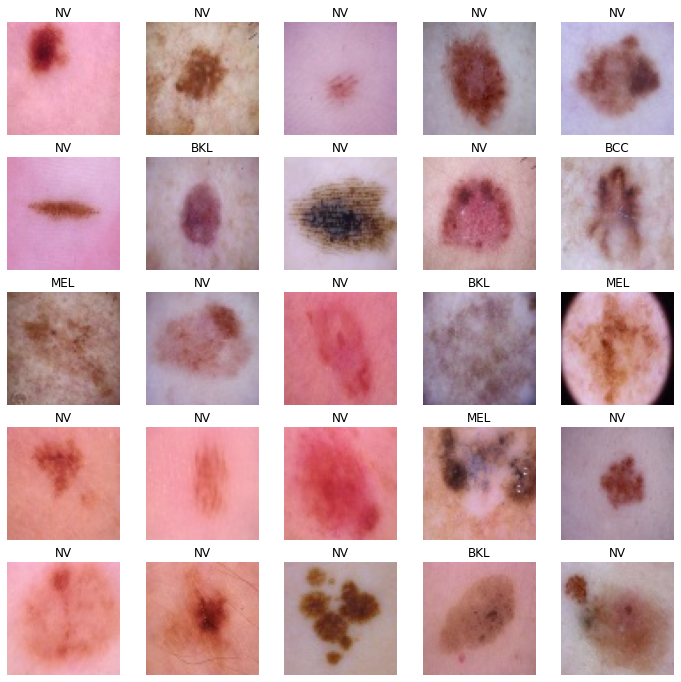

In [ ]:
def show_batch(x, y, figsize=12, subfigsize=5, n=25, no_axis=True):

  plt.figure(figsize=(figsize, figsize))
  
  for i in range(n):
      ax = plt.subplot(subfigsize, subfigsize, i+1)
      plt.imshow(x[i])
      plt.title(class_names[y[i]])
      if no_axis:
        plt.axis('off')
        
show_batch(x_test, y_test)

In [ ]:
def predictions(model, x_test, y_test, accuracy=True, axis=1):
  
  predictions = model.predict(x_test)
  pred = np.argmax(predictions, axis=axis)
  
  if accuracy:
    print("\nAccuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))
  
  return pred, x_test, y_test

In [ ]:
def trainable_model(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, 
                    fine_tuning=False, dropout=0.25, base_model='MobileNet', 
                    regularizer=0.01, learning_rate=1e-4, epochs=15, verbose=1, 
                    metrics='accuracy', pool_size=2, rotation_range=30, 
                    zoom_range=0.15, width_shift_range=0.2, shear_range=0.15, 
                    horizontal_flip=True, fill_mode="nearest", height_shift_range=0.2,
                    weights="imagenet", include_top=False, summary=False, 
                    valid_generator=False, callbacks=None, generator=True,
                    checkpoint=None):
  
  dataset = (x_train, y_train, x_val, y_val)

  BATCH_SIZE = batch_size
  INPUT_SHAPE = dataset[0][0].shape
  trainX = dataset[0]
  trainY = dataset[1]
  valX = dataset[2]
  valY = dataset[3]

  generators = ImageDataGenerator()
  train_dataset = generators.flow(trainX, trainY, batch_size=BATCH_SIZE)
  valid_dataset = generators.flow(valX, valY, batch_size=BATCH_SIZE)

  if generator:
    train_gen = ImageDataGenerator(rotation_range=rotation_range,
                                  zoom_range=zoom_range,
                                  width_shift_range=width_shift_range,
                                  height_shift_range=height_shift_range,
                                  shear_range=shear_range,
                                  horizontal_flip=horizontal_flip,
                                  fill_mode=fill_mode)

    train_dataset = train_gen.flow(trainX, trainY, batch_size=BATCH_SIZE)
    
    if valid_generator:
      valid_dataset = train_gen.flow(valX, valY, batch_size=BATCH_SIZE)
  
  if base_model in ['MobileNet','MobileNetV1']:
    base_model = MobileNet(weights=weights, 
                           include_top=include_top, 
                           input_tensor=Input(shape=INPUT_SHAPE)) # MobileNet: 83%, Epochs: 7

  elif base_model is 'MobileNetV2':
    base_model = MobileNetV2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # MobileNetV2: 75%, Epochs: 8

  elif base_model is 'VGG16':
    base_model = VGG16(weights=weights, 
                       include_top=include_top, 
                       input_tensor=Input(shape=INPUT_SHAPE)) # VGG16: 90%, Epochs: 7
  
  elif base_model in ['EfficientNetB0','EfficientNet']:
    base_model = EfficientNetB0(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # EfficientNetB0: 66%, Epochs: 6

  elif base_model is 'InceptionV3':
    base_model = InceptionV3(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Doesn't support by this dataset

  elif base_model is 'VGG19':
     base_model = VGG19(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # VGG19, 83%, Epochs: 10

  elif base_model is 'Xception':
    base_model = Xception(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Xception: 95%, Epochs: 9     

  elif base_model is 'DenseNet121':
    base_model = DenseNet121(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  elif base_model is 'DenseNet201':
    base_model = DenseNet201(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # DenseNet201: 82% Epochs: 6

  elif base_model is 'ResNet152V2':
    base_model = ResNet152V2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # ResNet152V2: 75%, Epochs: 6

  elif base_model is 'EfficientNetB5':
    base_model = EfficientNetB5(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  base_model.trainable=False

  if fine_tuning:
    base_model.trainable=True
    
  model = Sequential([base_model, 
                      AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                      Flatten(), 
                      Dense(64, activation='relu'),
                      Dropout(dropout), 
                      Dense(16, activation='relu'),
                      Dense(7, activation='softmax', kernel_regularizer=l2(regularizer)),
  ])

  model.compile(optimizer=Adam(lr=learning_rate), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=[metrics])

  if summary:
    model.summary()
  
  history = model.fit(train_dataset, 
                      epochs=epochs, 
                      validation_data=valid_dataset, 
                      verbose=verbose,
                      callbacks=[callbacks, checkpoint])
  
  _ = predictions(model, x_test, y_test)

  return history, model

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

checkpoints = ModelCheckpoint(f"HAM10000_Xception_dropout015_{accuracy*100:.2f}acc_epochs{epochs}.h5", verbose=1)

history, model = trainable_model(x_train, y_train, x_val, y_val, x_test, y_test,
                                 fine_tuning=True, epochs=20, base_model='Xception', 
                                 dropout=0.15, regularizer=0.1, batch_size=32, # regularizer=0.001, dropout=0.3
                                 callbacks=callbacks, summary=True, checkpoint=checkpoints)

# Best Models
# Xception: 91%, Epochs: 9
# Dropout: 0.05 -> 90.56%
# Dropout: 0.1 -> 93.76%
# Dropout: 0.125 -> 95.06%
# Dropout: 0.15 -> 95.21%
# Dropout: 0.16 -> 93.11%
# Dropout: 0.2 -> 94.76%
# Dropout: 0.25 -> 91.46%
# Dropout: 0.3 -> 91.20%

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2, 2, 2048)        20861480  
_________________________________________________________________
average_pooling2d_5 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_17 (Dense)             (None, 7)                

In [ ]:
# Save the models to Google Drive
copy("/content/HAM10000_Xception_dropout0.15_batch_size32_0.977.h5", "/content/drive/MyDrive/datasets")

# Saved it to google drive: https://drive.google.com/file/d/1MD5uNWDpFcmihJcr7CEMsdkCvJV6eAuY/view?usp=sharing <- here is the links

'/content/drive/MyDrive/datasets/HAM10000_Xception_dropout0.15_batch_size32_0.977.h5'

In [ ]:
# Load the saved models/checkpoints models from Google Drive

def load_models(url, summary=False):
  model_download = download_file(url, unzip=False, remove_after_unzip=True, google_drive=True, ext=".h5")  
  model = load_model(model_download)
  if summary:
    model.summary()
  return model

links = 'https://drive.google.com/file/d/1MD5uNWDpFcmihJcr7CEMsdkCvJV6eAuY/view?usp=sharing'
model = load_models(links)

In [ ]:
# Scoring saved models/checkpoint models

def scoring(model, x_test, y_test, verbose=0, returning='confusion_matrix'):

  
  score = model.evaluate(x_test, y_test, verbose=verbose)
  predicting = model.predict(x_test)
  pred = np.argmax(predicting, axis=1)
  conf = confusion_matrix(y_test, pred)  
  
  if returning in ['score', 'scoring']:
    return score
  
  if returning in ['predicting', 'pred', 'predict']:
    return pred

  if returning in ['conf', 'confusion_matrix', 'confussion', 
                   'confusion', 'conf_mat', 'confusion_mat']:
    return conf

score = scoring(model, x_test, y_test, returning='score')
confusion_mat = scoring(model, x_test, y_test, returning='confusion_mat')

In [ ]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 96.66%


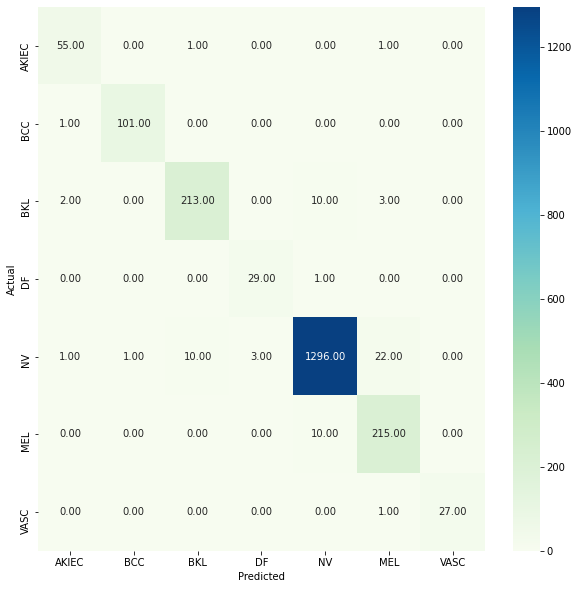

In [ ]:
def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
  fig, ax = plt.subplots(figsize=(10,10))
  
  sn.heatmap(conf, annot=True, fmt='.2f',
            xticklabels=[f"{c}" for c in class_names], 
            yticklabels=[f"{c}" for c in class_names],
            cmap=cmap)
  
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

plot_confusionmat(confusion_mat, class_names)

Saving beginicaramengobatibasalcellcarcinoma.jpg to beginicaramengobatibasalcellcarcinoma.jpg


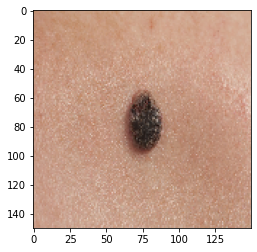


Predicting: Melanocytic nevi
Kind of Cancer: Benign


In [ ]:
# test some picture here

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  
  plt.imshow(load_img(path, target_size=(150, 150)))
  plt.show()
  
  img = load_img(path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  predictions = model.predict(images)
  pred = np.argmax(predictions, axis=1)
  
  print(f"\nPredicting: {class_names_long[pred[0]]}")
  if class_names_long[pred[0]] != 'Melanoma':
    print("Kind of Cancer: Benign")
  else:
    print("Kind of Cancer: Malignant")